# Extract Line P from gridded Arg

Roemmich-Gilson Argo climatology available from: https://sio-argo.ucsd.edu/RG_Climatology.html

```bash
mkdir -p data/roemmich-gibson
cd data/roemmich-gibson
wget https://sio-argo.ucsd.edu/RG/RG_ArgoClim_Salinity_2019.nc.gz
wget https://sio-argo.ucsd.edu/RG/RG_ArgoClim_Temperature_2019.nc.gz
for i in $(seq -f "%02g" 1 12); do wget "https://sio-argo.ucsd.edu/RG/RG_ArgoClim_2019${i}_2019.nc.gz"; done
for i in *.gz; do gunzip $i; done
```

In [1]:
import gsw
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

from shapely.geometry import LineString, Point

import datetime
from pathlib import Path


In [2]:
### CONFIGURABLE PARAMETERS
BUFFER = 1 # In geographic degrees, how big of a search radius around Line P
LON_RANGE = slice(205, 245) # Longitude range to search
LAT_RANGE = slice(45, 55) # Latitude range to search
RG_DATAPATH = Path("/Users/ashao/data/roemmich-gibson") # The path where the Argo dataset lives
OUTPUT_FILENAME = "argo_dataset_linep.csv"


In [3]:
# Load original dataset (2004-2019)
ds_original = xr.open_mfdataset(
  [
    RG_DATAPATH/"RG_ArgoClim_Salinity_2019.nc",
    RG_DATAPATH/"RG_ArgoClim_Temperature_2019.nc"
  ],
  decode_times=False
)

# Load 2019 dataset
files_2019 = [RG_DATAPATH / f"RG_ArgoClim_2019{mon+1:02d}_2019.nc" for mon in range(12)]
ds_2019 = xr.open_mfdataset(files_2019, decode_times=False)

/var/folders/1c/yhj0kv6n5jq84j1048lny2dc0000gp/T/ipykernel_90920/3625998624.py:2: FutureWarning: In a future version of xarray the default value for compat will change from compat='no_conflicts' to compat='override'. This is likely to lead to different results when combining overlapping variables with the same name. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set compat explicitly.
  ds_original = xr.open_mfdataset(
/var/folders/1c/yhj0kv6n5jq84j1048lny2dc0000gp/T/ipykernel_90920/3625998624.py:2: FutureWarning: In a future version of xarray the default value for compat will change from compat='no_conflicts' to compat='override'. This is likely to lead to different results when combining overlapping variables with the same name. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set compat explicitly.
  ds_original = xr.open_mfdataset(


In [4]:
# Calculate the actual temperature and salinity from the original datasets
calc_actual = lambda clim, anomaly1, anomaly2: xr.concat([clim+anomaly1, clim+anomaly2], dim="TIME")
temperature = calc_actual(ds_original.ARGO_TEMPERATURE_MEAN, ds_original.ARGO_TEMPERATURE_ANOMALY, ds_2019.ARGO_TEMPERATURE_ANOMALY)
salinity = calc_actual(ds_original.ARGO_SALINITY_MEAN, ds_original.ARGO_SALINITY_ANOMALY, ds_2019.ARGO_SALINITY_ANOMALY)

ds_actual = xr.Dataset()
ds_actual["temperature"] = temperature
ds_actual["salinity"] = salinity

In [5]:
year0 = 2004
years = (ds_actual.TIME//12) + year0
months = ((ds_actual.TIME-0.5)%12)+1
ds_actual["TIME"] = [datetime.datetime(int(year), int(month), day=15) for year, month in zip(years,months)]

In [6]:
linep_longitudes = np.array([-126.667,-127.167,-127.667,-128.167,-128.667,-129.167,-129.667,-130.167,-130.667,-131.667,-132.667,-133.667,-134.667,-135.667,-136.667,-137.667,-138.667,-139.667,-140.667,-141.667,-142.667,-143.605,-145.000,-144.303])
linep_latitudes = np.array([48.650,48.692,48.743,48.777,48.817,48.857,48.893,48.933,48.970,49.043,49.123,49.200,49.283,49.350,49.433,49.500,49.567,49.633,49.700,49.767,49.837,50.000,50.000,50.000])
linep_longitudes += 360 # Shift to 0-360

# Make a line that represents Line P with a buffer of 1-degree around it
linep_geom = LineString(zip(linep_longitudes, linep_latitudes)).buffer(BUFFER)

# Truncate the dataset to make searching faster
ds_truncated = ds_actual.sel(LONGITUDE=LON_RANGE, LATITUDE=LAT_RANGE)
longrid, latgrid = np.meshgrid(ds_truncated.LONGITUDE, ds_truncated.LATITUDE)

# Get coordinates of every point and check to see if it's in the the buffered line
coords = zip(longrid.ravel(), latgrid.ravel())
points = [Point(lon, lat) for lon, lat in coords]
in_linep = [linep_geom.contains(point) for point in points]
in_linep = np.reshape(np.array(in_linep), longrid.shape)

# Make the mask a DataArray
coords = {coord: ds_truncated.coords[coord] for coord in ["LATITUDE", "LONGITUDE"]}
in_linep = xr.DataArray(data=in_linep, coords=coords)

# Extract just the parts of temperature and salinity
ds_linep = xr.Dataset()
ds_linep["temperature"] = ds_truncated.temperature.where(in_linep, drop=True)
ds_linep["salinity"] = ds_truncated.salinity.where(in_linep, drop=True)


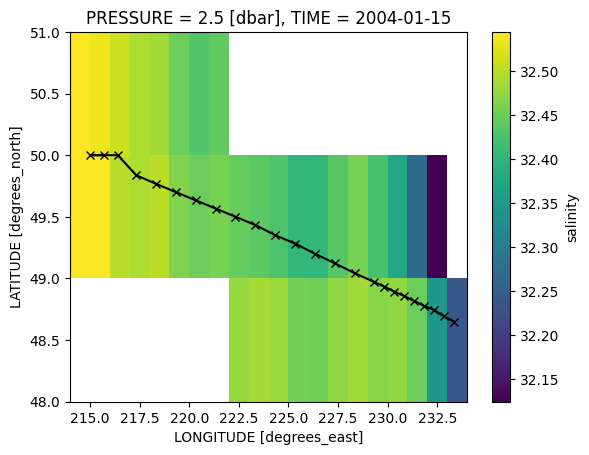

In [7]:
ds_linep.salinity[0,:,:,0].plot()
plt.plot(linep_longitudes, linep_latitudes, 'x-', color="black")

In [8]:
# Make a pandas dataframe that is ordered in a way that makes sense
# in order of fastest varying dimensions: pressure, longitude, latitude, time
ds_linep_valid = ds_linep.stack(points=["LATITUDE", "LONGITUDE"]).dropna("points")
df = ds_linep_valid.to_dataframe(
  dim_order=["TIME", "points", "PRESSURE"]
).reset_index()

In [9]:
# Calculate depth
df["DEPTH"] = -gsw.z_from_p(df.PRESSURE, df.LATITUDE)

In [10]:
# Make sure all names are capitalized
df = df.rename(columns={name: name.upper() for name in df.keys()})

# Permute the columns to match hydrographic data
column_order = [
  "TIME",
  "LATITUDE",
  "LONGITUDE",
  "DEPTH",
  "PRESSURE",
  "TEMPERATURE",
  "SALINITY"
]
df = df.reindex(columns=column_order)

# Reset time to strings
datestr = [time.strftime("%Y-%m-%d") for time in df["TIME"]]
df["TIME"] = datestr

In [11]:
header = '''
# Temperature and salinity extracted from a 1-degree region around
# Line P from the Roemmich and Gilson Argo dataset. That dataset
# contains a climatology created from 2004-2018 and provides monthly
# anomalies. The anomaly fields are concatenated with those from
# 2019. The actual temperature and salinity are thus calculated as
# Actual = Anomaly(month) + Climatology
#
# Depth: meters calculated from pressure using gsw.z_from_p
# Pressure: dbar
# Temperature: in-situ temperature in Celsius
# Salinity: PSS-78
'''

with open(OUTPUT_FILENAME, "w") as f:
  f.write(header)
  f.write(f"# Created: {datetime.date.today()}\n")
  df.to_csv(f, mode="a", index=False, na_rep="NaN")
